In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting
from collections import Counter

# plt.style.use('ggplot')
plt.style.use('bmh')
# mpl.use("pgf")
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),

    # saving settings for latex
    # https://timodenk.com/blog/exporting-matplotlib-plots-to-latex/
    # "pgf.texsystem": "pdflatex",
    # "font.family": "serif",
    # "text.usetex": True,
    # "pgf.rcfonts": False,
    })

%matplotlib inline

In [54]:
# load the dataset and the extra data
df = pd.read_csv("./data/cad/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

df_7y = pd.read_csv("./data/cad/data_feat.csv", index_col=0, decimal='.')
df = df.merge(df_7y["Survive7Y"], how="left", left_index=True, right_index=True)

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
# df.info()

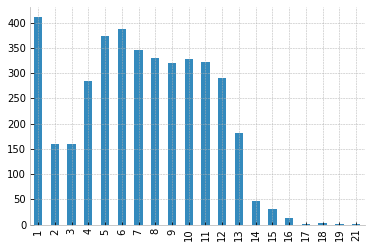

In [55]:
# birth event: "Data prelievo"
# death event: "Death7Y"
# right-censoring occur if the patient is still alive at "Follow Up Data"

# duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: (x.days//365) + 1)
df_surv["observed"] = df["CVD Death"]

# plot duration
df_surv["duration"].value_counts().sort_index().plot(kind='bar')
df_feat = pd.read_csv("./data/cad/data_feat.csv", index_col=0, decimal='.')
df_surv = df_feat.merge(df_surv, how="left", left_index=True, right_index=True)
df_surv.to_csv("data/cad/data_surv.csv")


### 1- Survival Analysis On All The CAD Patients 
The plot indicates the % of CVD patients that survived after n years. For example, the probability for surviving more than 7 years is ~92%.

<AxesSubplot:title={'center':'Survival Function of CVD Patients (7 Years)'}, xlabel='Years', ylabel='Survive7Y'>

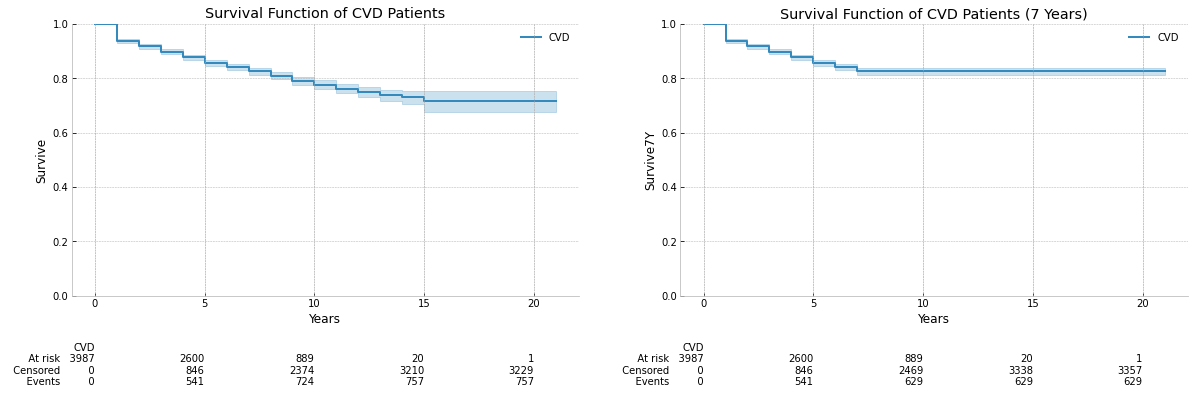

In [57]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

# plt.savefig("")
# kmf.median_survival_time_
# kmf.confidence_interval_

49.580135440180584


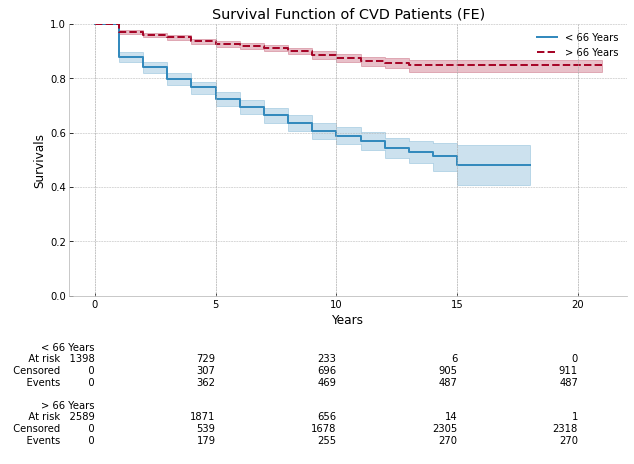

In [80]:
age_mean = df_surv["FE"].mean()

df_under_mean = df_surv[df_surv["FE"] < age_mean]
df_above_mean = df_surv[df_surv["FE"] > age_mean]

fig = plt.figure(figsize=(10, 5)) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"< {66 Years")
kmf1.plot_survival_function()

kmf2 = KaplanMeierFitter()
kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"> 66 Years")
kmf2.plot_survival_function(linestyle="--")

plt.title('Survival Function of CVD Patients (FE)')
plt.xlabel("Years")
plt.ylabel("Survivals")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1, kmf2)
# plt.tight_layout()
print(age_mean)

### 2- Survival Analysis CAD Prediction Indicator (Test set)

In [59]:
def plot_kmf(df, threshold):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")

    plt.title('Survival Function of CAD Patients (Model Prediction Indicator)')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

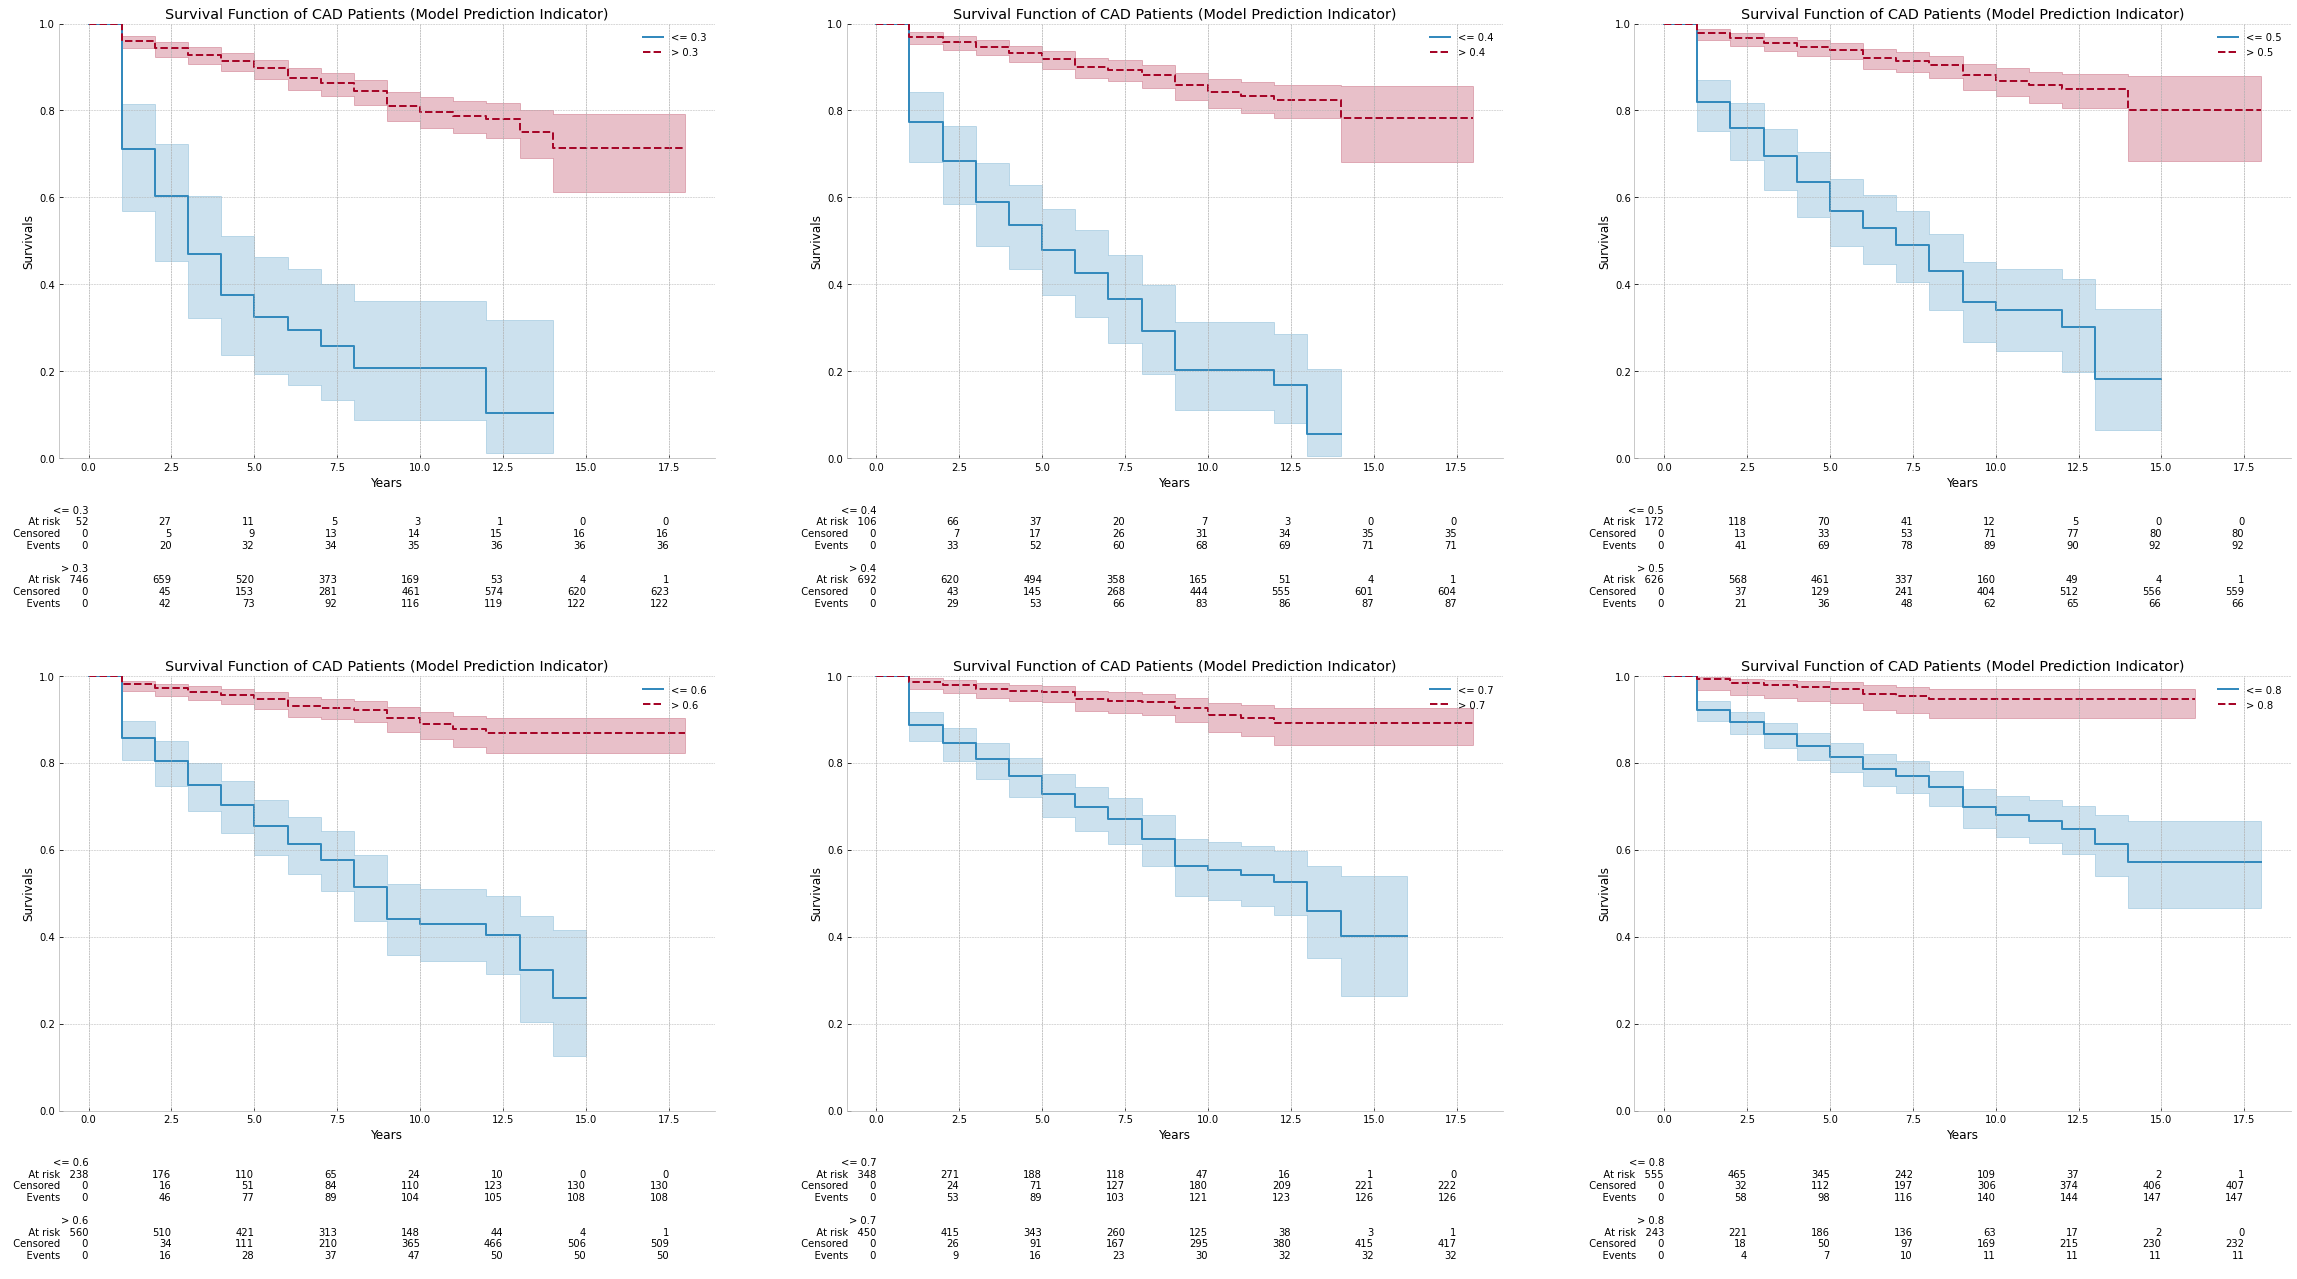

In [60]:
df_out = pd.read_csv("./data/cad/extra_test_output.csv", index_col=0, decimal='.')

df_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_pred = df_pred.merge(df_out, how="left", left_index=True, right_index=True)

# Plots
fig = plt.figure(figsize=(40, 20)) 
fig_dims = (2, 3)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_pred, threshold=0.3)

plt.subplot2grid(fig_dims, (0, 1))
plot_kmf(df_pred, threshold=0.4)

plt.subplot2grid(fig_dims, (0, 2))
plot_kmf(df_pred, threshold=0.5)

plt.subplot2grid(fig_dims, (1, 0))
plot_kmf(df_pred, threshold=0.6)

plt.subplot2grid(fig_dims, (1, 1))
plot_kmf(df_pred, threshold=0.7)

plt.subplot2grid(fig_dims, (1, 2))
plot_kmf(df_pred, threshold=0.8)

In [76]:
df_regr = df_surv.drop(columns=["Survive7Y", "Death7Y"])

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_regr, duration_col='duration', event_col='observed')
cph.print_summary()  # access the individual results using cph.summary

/home/dot/miniconda3/envs/ipoteri/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 3987 total observations, 3230 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 3987
number of events observed = 757
   partial log-likelihood = -5513.51
         time fit was run = 2022-03-23 10:38:19 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Gender (Male = 1)                            -0.06       0.94       0.09            -0.24             0.12                 0.79                 1.13
Age                                           0.06       1.06       0.00             0.05             0.07                 1.05                 1.07
Angina                                       -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
Previous CABG                                 0.19       1.21       0.09             0.01             0.37                 1.01                 1.45
Previous PCI                                 -0.10       0.91       0.09            -0.28             0.09                 0.76                 1.09
Previous Myocardial Infarction                0.25       1.28       0.08             0.08             0.41                 1.09                 1.51
Acute Myocardial Infarction                   0.16       1.18       0.11            -0.05             0.37                 0.95                 1.45
Angiography                                  -1.00       0.37       0.17            -1.35            -0.66                 0.26                 0.52
Vessels                                       0.26       1.30       0.05             0.17             0.35                 1.19                 1.43
FE                                           -0.06       0.95       0.00            -0.06            -0.05                 0.94                 0.95
Documented resting \nor exertional ischemia  -0.06       0.94       0.09            -0.23             0.11                 0.79                 1.11
Post-ischemic Dilated\nCardiomyopathy        -0.28       0.76       0.12            -0.51            -0.05                 0.60                 0.95
Smoke\nHistory of smoke                       0.10       1.10       0.08            -0.06             0.26                 0.94                 1.29
Diabetes\nHistory of diabetes                 0.31       1.36       0.08             0.15             0.46                 1.17                 1.58
Hypertension\nHistory of hypertension        -0.01       0.99       0.08            -0.16             0.14                 0.85                 1.15
Hyperlipemia\nHistoty of hyperlipemia        -0.52       0.60       0.08            -0.68            -0.36                 0.51                 0.70
Paroxysmal or chronic \natrial fibrillation   0.36       1.43       0.09             0.18             0.54                 1.19                 1.71

                                              cmp to      z      p   -log2(p)
covariate                                                                    
Gender (Male = 1)                               0.00  -0.63   0.53       0.93
Age                                             0.00  13.00 <0.005     125.87
Angina                                          0.00  -0.15   0.88       0.18
Previous CABG                                   0.00   2.03   0.04       4.57
Previous PCI                                    0.00  -1.03   0.30       1.73
Previous Myocardial Infarction                  0.00   2.95 <0.005       8.29
Acute Myocardial Infarction                     0.00   1.52   0.13       2.96
Angiography                                     0.00  -5.77 <0.005      26.87
Vessels             